# Imports

['AMT_PAYMENT', 'DAYS_CREDIT_ENDDATE', 'DAYS_FIRST_DRAWING','DAYS_BIRTH_disc_int___19282__13234_',
       'CNT_PAYMENT','DAYS_BIRTH_disc_int___25229__19283_','NAME_EDUCATION_TYPE_discret_lower','EXT_SOURCE_2_disc_int__0_0_0_09_', 'EXT_SOURCE_2_disc_int__0_45_0_85_','REGION_RATING_CLIENT_W_CITY','DAYS_CREDIT_ENDDATE','RATE_DOWN_PAYMENT']
       
Colonnes à traiter dans train_prepared : EXT_SOURCE_2_disc_int (2 modalités) ; DAYS_BIRTH ; NAME_EDUCATION_TYPE ; REGION_RATING_CLIENT_W_CITY ; NAME_CONTRACT_TYPE
Colonnes à traiter dans installment payment : AMT_PAYMENT
Colonnes à traiter dans previous_application : CNT_PAYMENT ; DAYS_FIRST_DRAWING ; RATE_DOWN_PAYMENT
Colonnes à traiter dans bureau : DAYS_CREDIT_ENDDATE

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

from data_preparation import *
import warnings
warnings.filterwarnings("ignore")

In [100]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()
train_prepared['DAYS_BIRTH'] = df_app['DAYS_BIRTH'].copy()
train_prepared['NAME_EDUCATION_TYPE'] = df_app['NAME_EDUCATION_TYPE'].copy()
train_prepared['EXT_SOURCE_2'] = df_app['EXT_SOURCE_2'].copy()
train_prepared['OCCUPATION_TYPE'] = df_app['OCCUPATION_TYPE'].copy()
train_prepared['NAME_INCOME_TYPE'] = df_app['NAME_INCOME_TYPE'].copy()

train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared = train_prepared[['SK_ID_CURR', 'DAYS_BIRTH' , 'NAME_EDUCATION_TYPE' , 'REGION_RATING_CLIENT_W_CITY' , 'NAME_CONTRACT_TYPE','TARGET','date_mensuelle', 'EXT_SOURCE_2' , 'OCCUPATION_TYPE','NAME_INCOME_TYPE', ]]

In [101]:
train_prepared['OCCUPATION_TYPE'].isna().sum()

96049

# Bureau

In [102]:
df_bur = pd.read_csv('./data/bureau.csv')

In [103]:
df_bur_group = df_bur[['DAYS_CREDIT_ENDDATE','SK_ID_CURR']].groupby('SK_ID_CURR').sum()
df_bur_group.reset_index(inplace=True)

# Previous_application

In [104]:
df_prev = pd.read_csv('./data/previous_application.csv')

In [105]:
df_prev_group = df_prev[['SK_ID_CURR', 'CNT_PAYMENT' , 'DAYS_FIRST_DRAWING' , 'RATE_DOWN_PAYMENT']].groupby('SK_ID_CURR').sum()
df_prev_group.reset_index(inplace=True)

# Installment

In [106]:
df_ins = pd.read_csv('./data/installments_payments.csv')

In [107]:
df_ins_group = df_ins[['SK_ID_CURR', 'AMT_PAYMENT']].groupby('SK_ID_CURR').sum()
df_ins_group.reset_index(inplace=True)

# Merging

In [108]:
train_prepared = train_prepared.merge(df_bur_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_prev_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_ins_group, on = 'SK_ID_CURR', how = 'left')

# NaN

In [109]:
for col in train_prepared.columns:
    if train_prepared[col].isna().sum()>100000:
        train_prepared = train_prepared.drop(columns = col)
    elif train_prepared[col].dtype=='object' :
        mode = train_prepared[col].mode()
        train_prepared[col] = train_prepared[col].fillna(mode)
    else : 
        train_prepared[col] = train_prepared[col].fillna(0)

In [110]:
train_prepared.columns

Index(['SK_ID_CURR', 'DAYS_BIRTH', 'NAME_EDUCATION_TYPE',
       'REGION_RATING_CLIENT_W_CITY', 'NAME_CONTRACT_TYPE', 'TARGET',
       'date_mensuelle', 'EXT_SOURCE_2', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE',
       'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int', 'DAYS_CREDIT_ENDDATE',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'RATE_DOWN_PAYMENT',
       'AMT_PAYMENT'],
      dtype='object')

# Discretisation

Discrétisation des variables numériques en cours ... 


  0%|          | 0/7 [00:00<?, ?it/s]

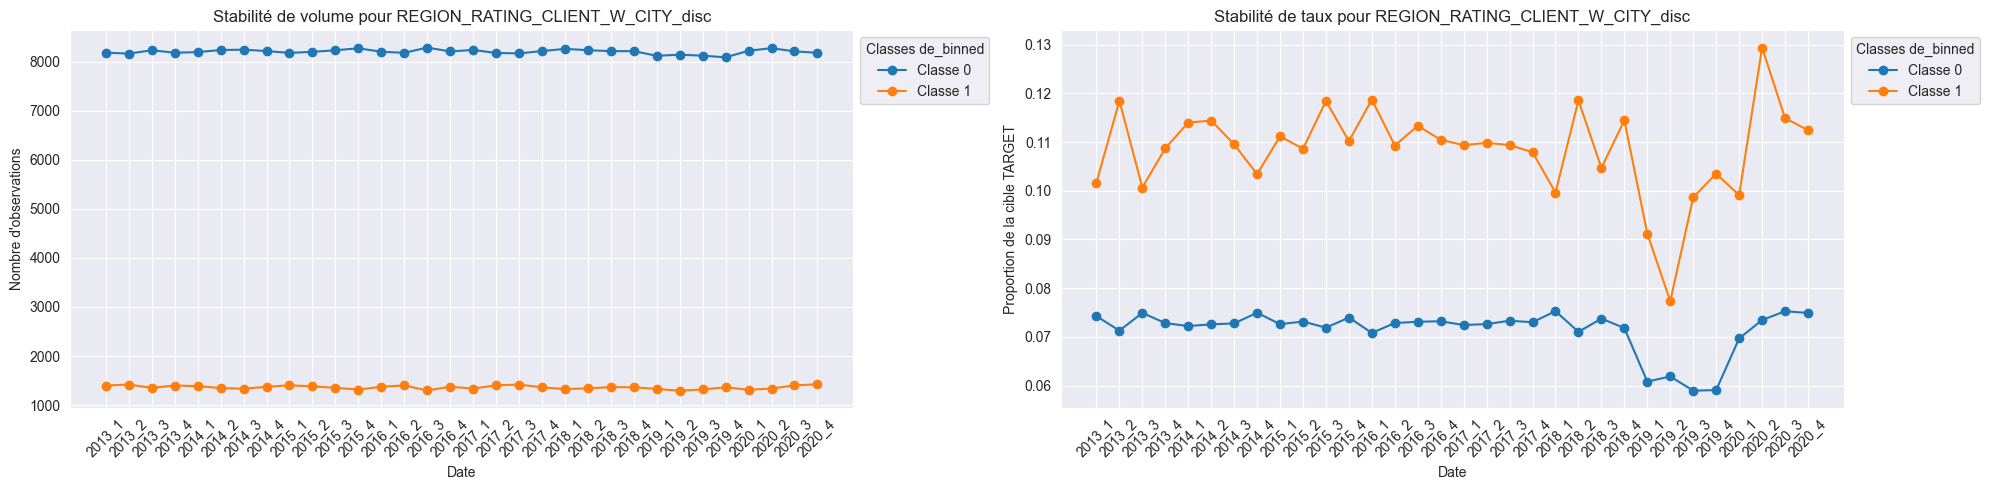

 14%|█▍        | 1/7 [00:13<01:22, 13.81s/it]

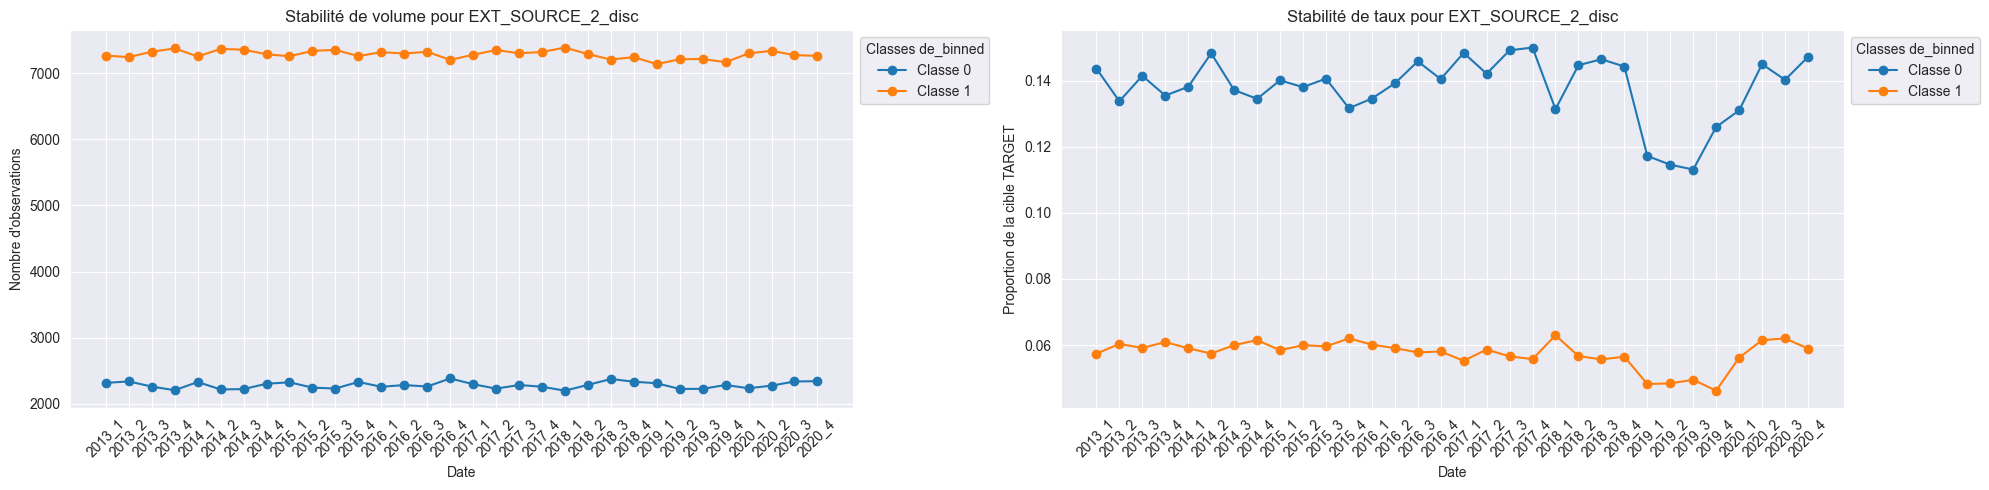

 29%|██▊       | 2/7 [00:27<01:08, 13.63s/it]

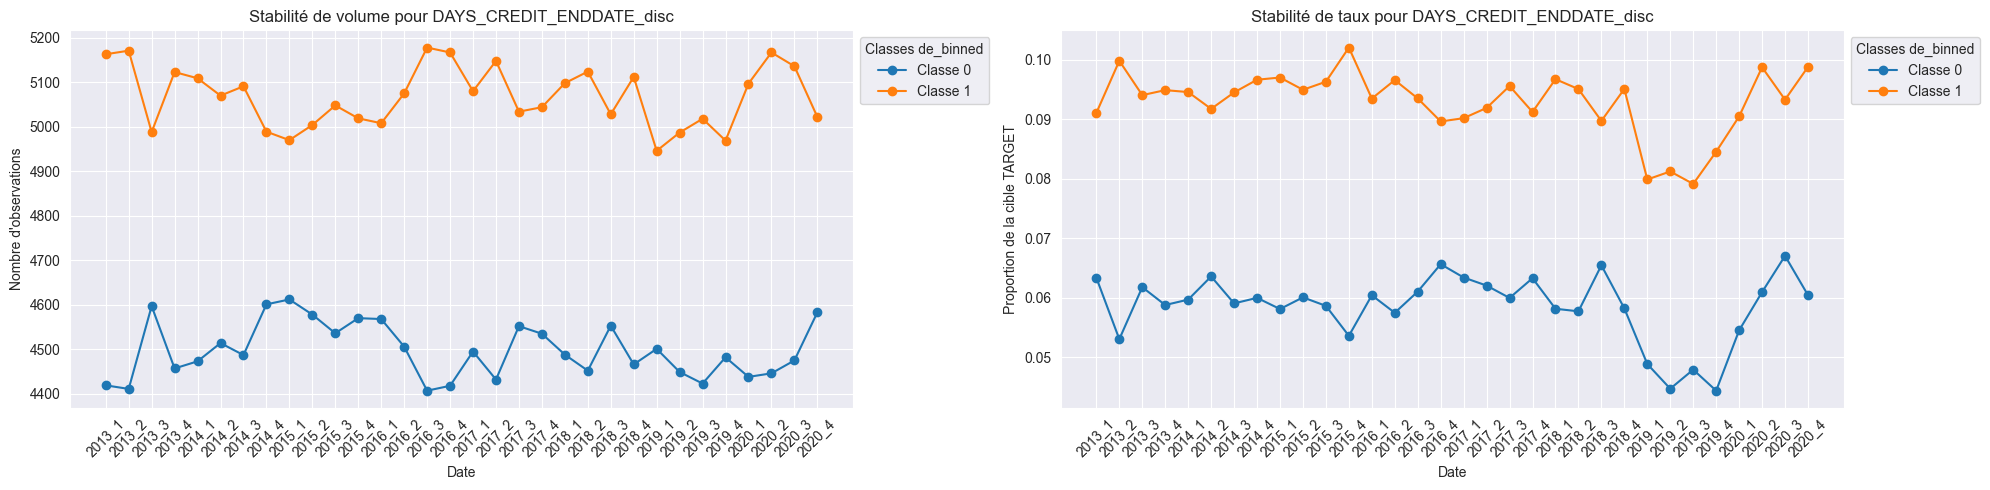

 43%|████▎     | 3/7 [00:40<00:53, 13.42s/it]

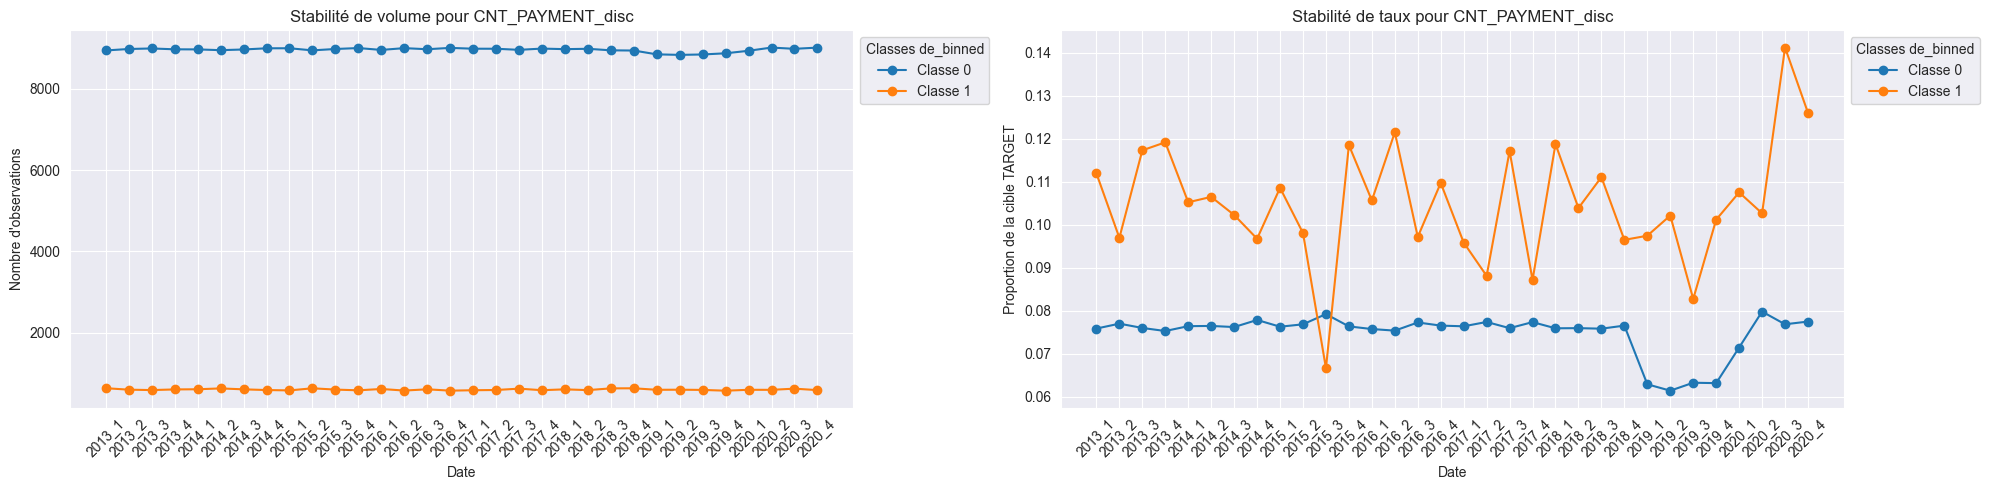

 57%|█████▋    | 4/7 [00:53<00:40, 13.37s/it]

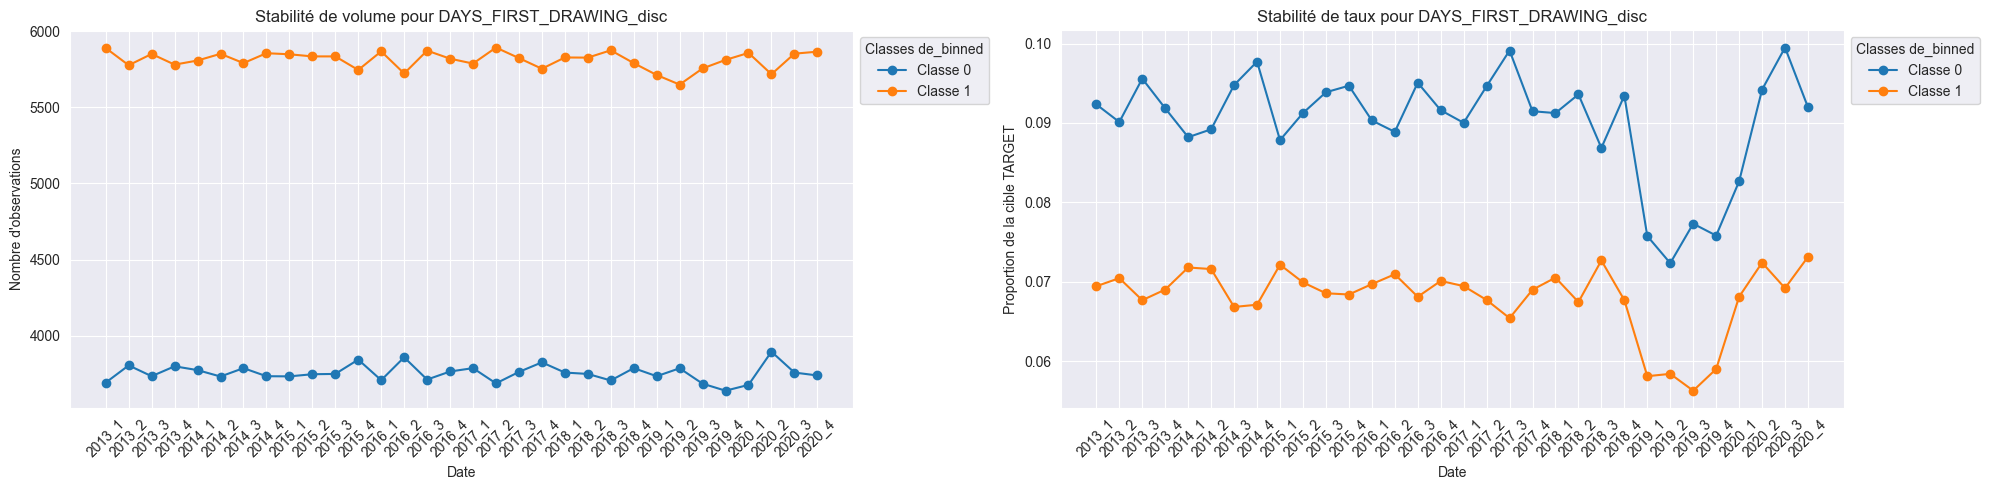

 71%|███████▏  | 5/7 [01:07<00:26, 13.32s/it]

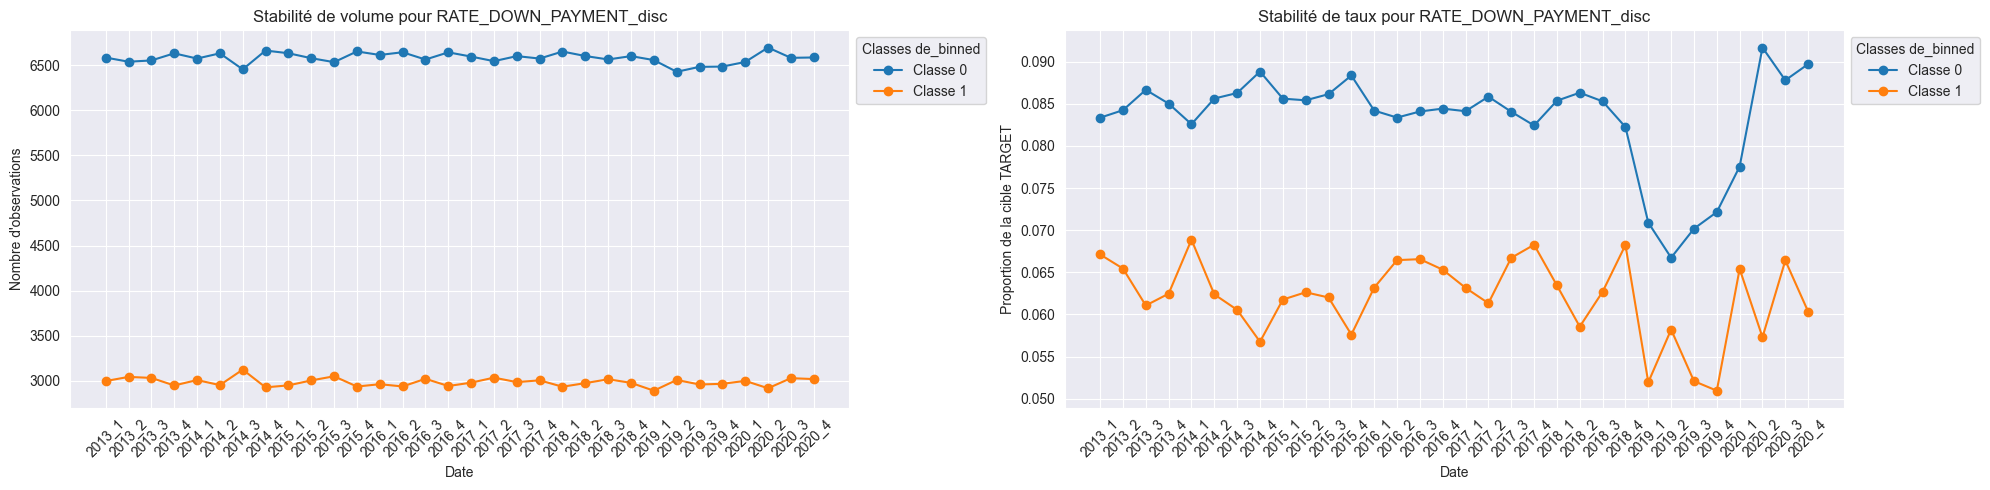

 86%|████████▌ | 6/7 [01:18<00:12, 12.81s/it]

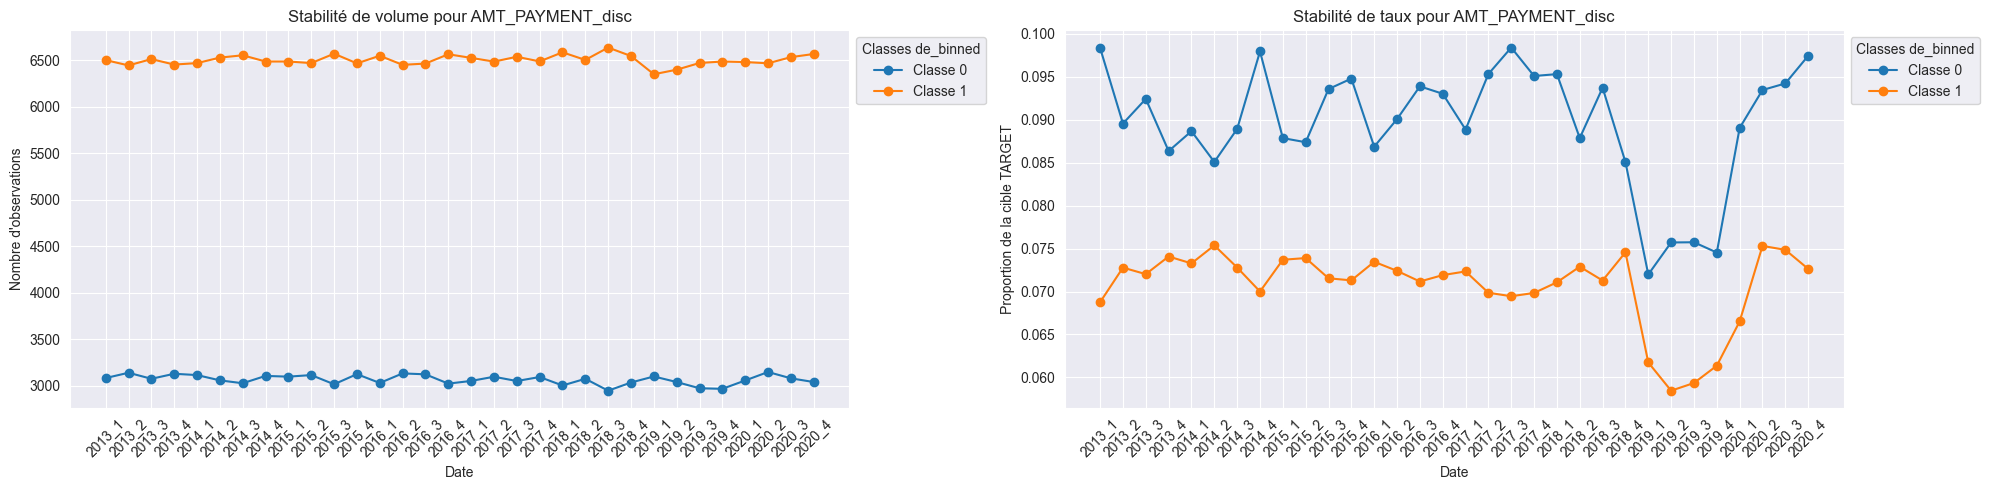

100%|██████████| 7/7 [01:31<00:00, 13.10s/it]

Variables numériques discrétisées ✅


In [111]:
dataprep = DataPreparation(train = train_prepared, nan_treshold = 0.4, plot = True)
dataprep.numericals_discretisation()

In [112]:
dataprep.categorical_discretisation()

Discrétisation des variables catégorielles en cours ... 


In [113]:
train_prepared_sauv = train_prepared.copy()

In [114]:
train_prepared = train_prepared_sauv.copy()

In [115]:
train_prepared = train_prepared[['SK_ID_CURR','REGION_RATING_CLIENT_W_CITY_disc',
       'REGION_RATING_CLIENT_W_CITY_disc_int', 'EXT_SOURCE_2_disc',
       'EXT_SOURCE_2_disc_int', 'DAYS_CREDIT_ENDDATE_disc',
       'DAYS_CREDIT_ENDDATE_disc_int',
       'CNT_PAYMENT_disc_int', 'DAYS_FIRST_DRAWING_disc',
       'DAYS_FIRST_DRAWING_disc_int', 'RATE_DOWN_PAYMENT_disc',
       'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc',
       'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret',
       'OCCUPATION_TYPE_discret','NAME_CONTRACT_TYPE','date_mensuelle','TARGET','EXT_SOURCE_1_disc_int','EXT_SOURCE_3_disc_int']]

In [116]:
train_prepared['NAME_INCOME_TYPE_discret'] = train_prepared['NAME_INCOME_TYPE_discret'].apply(lambda x : 'other' if x =='low_income' else x)

# Data viz

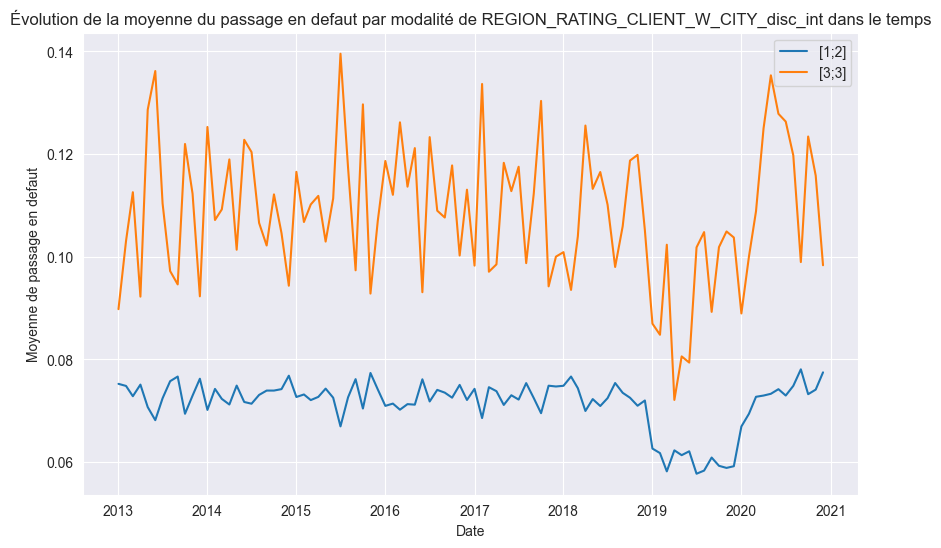

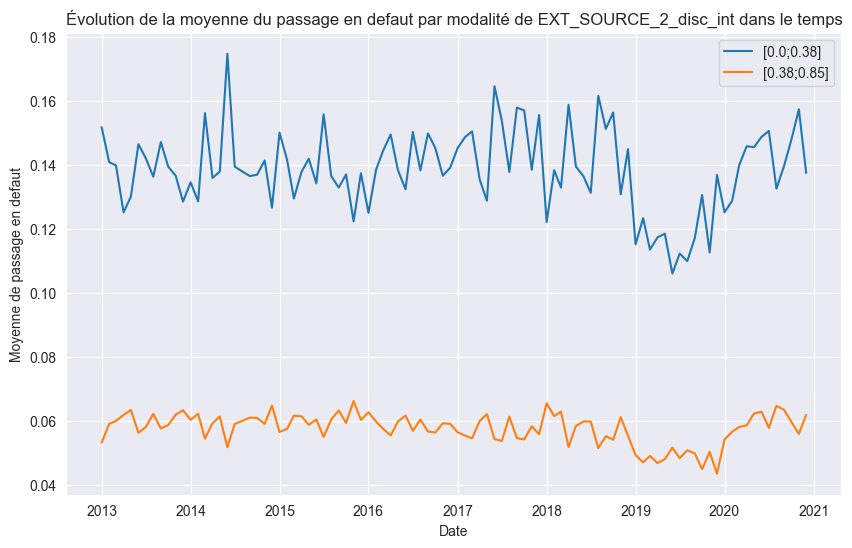

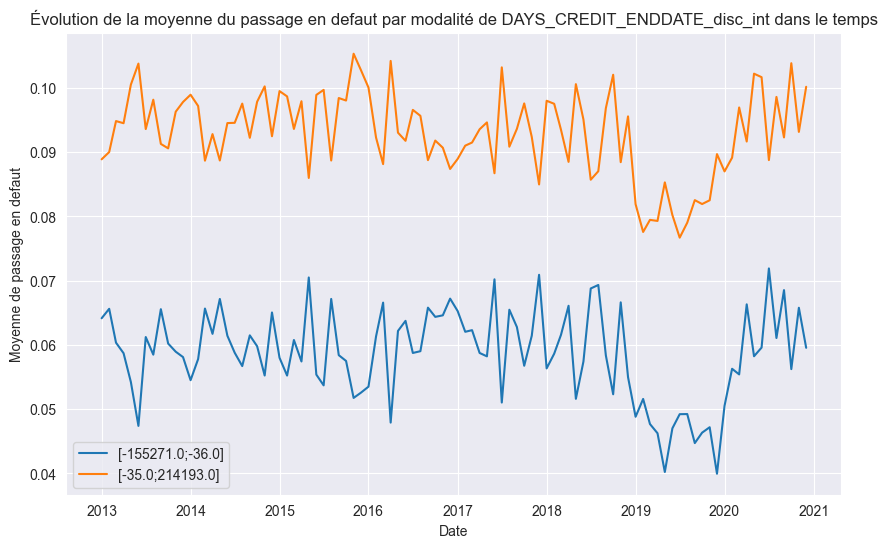

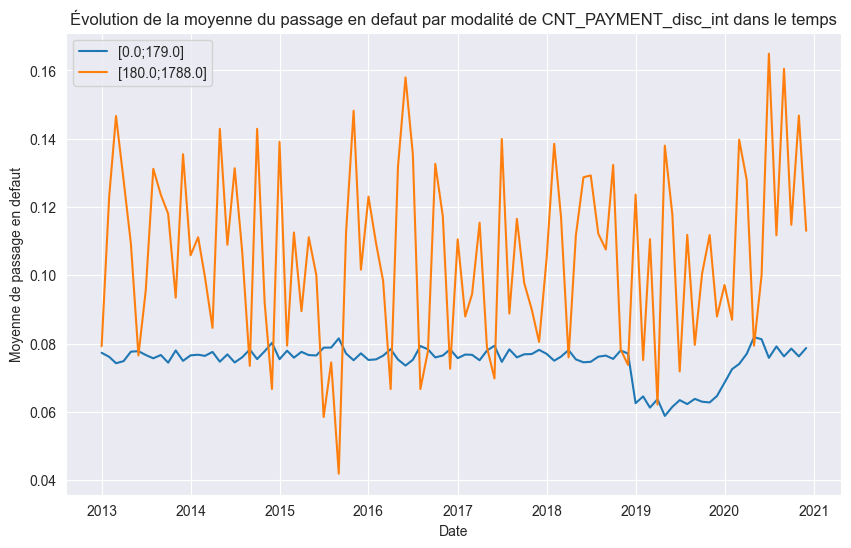

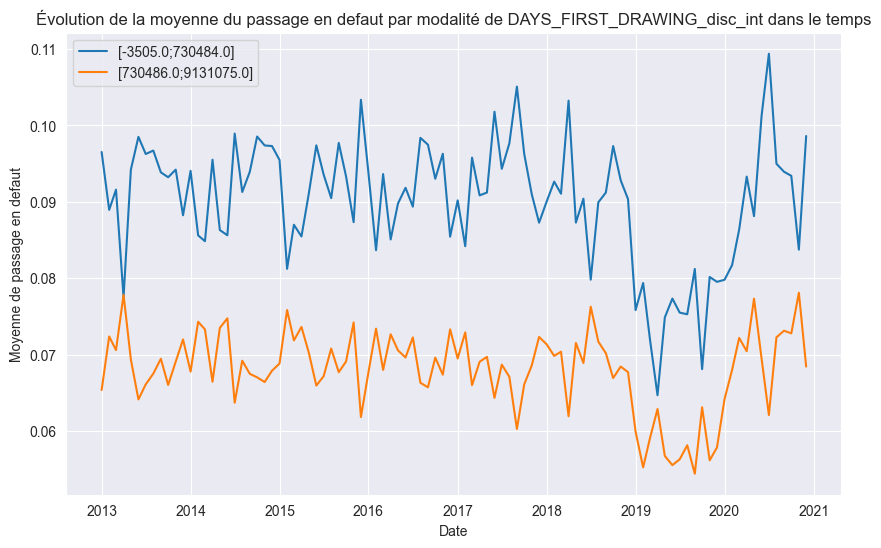

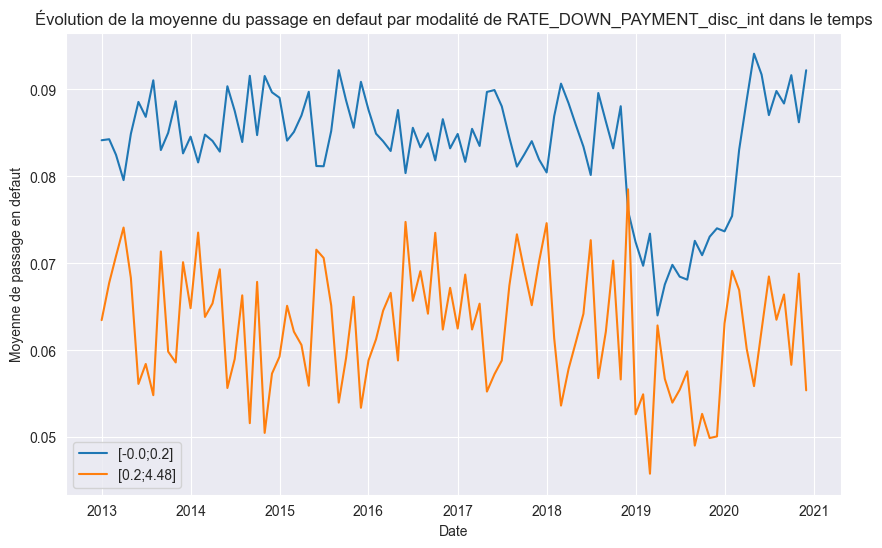

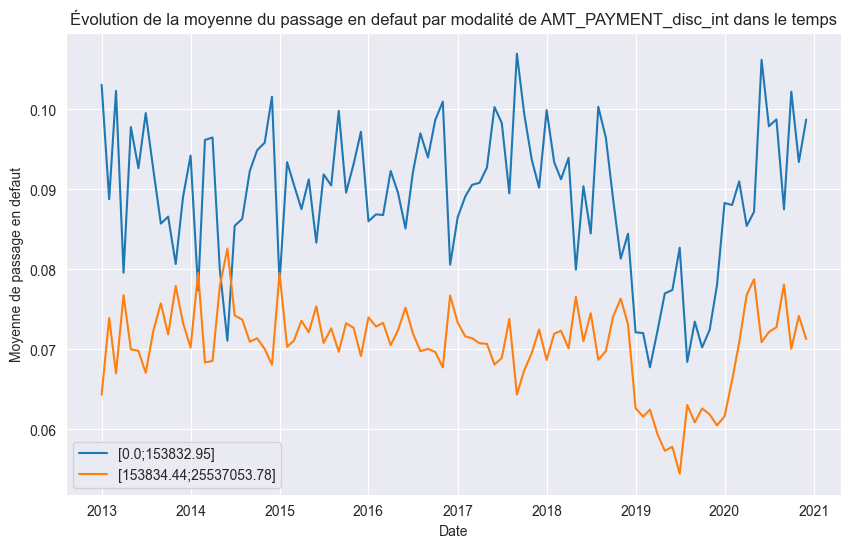

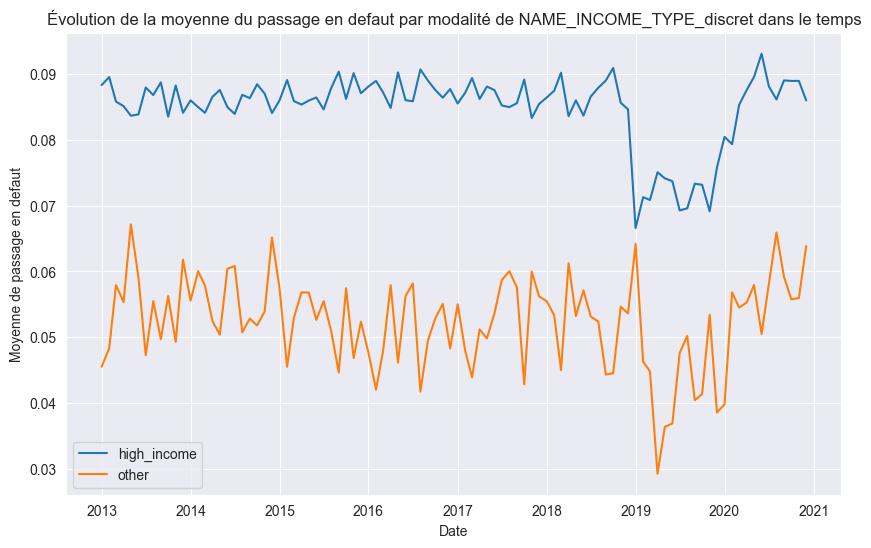

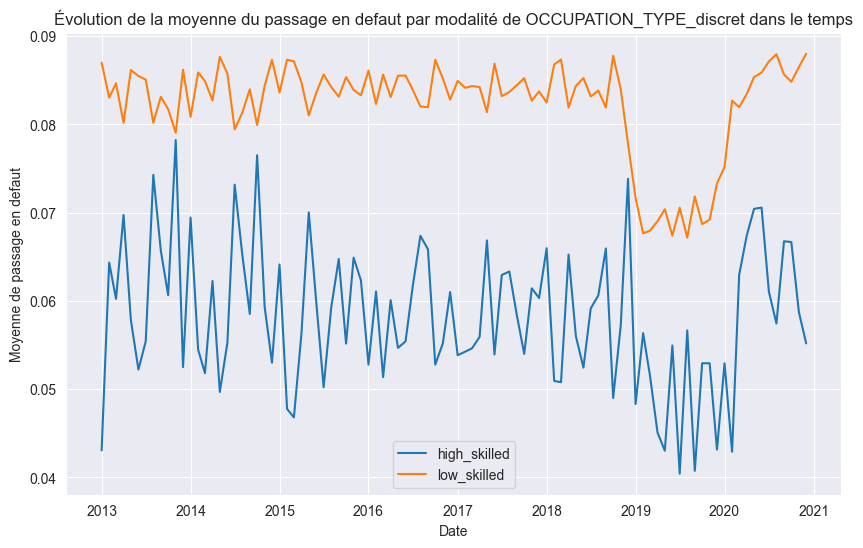

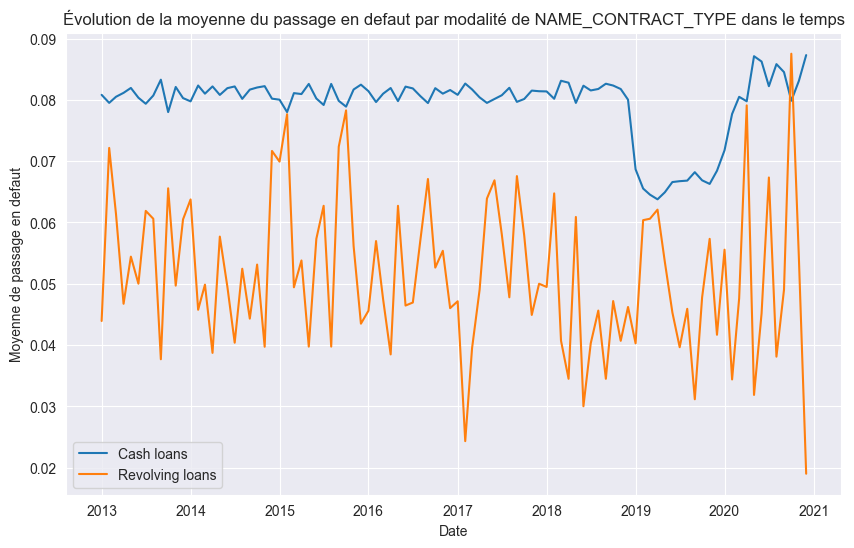

In [75]:
for col in train_prepared.select_dtypes(include = 'object').columns:
    result = train_prepared.groupby([col, 'date_mensuelle'])['TARGET'].mean().reset_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    for genre, group in result.groupby(f'{col}'):
        ax.plot(group['date_mensuelle'], group['TARGET'], label=f'{genre}')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Moyenne de passage en defaut')
    ax.set_title(f'Évolution de la moyenne du passage en defaut par modalité de {col} dans le temps')
 
    plt.show()

In [117]:
X = train_prepared.drop(columns=['date_mensuelle'])
y = train_prepared['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Logit statsmodels

Optimization terminated successfully.
         Current function value: 0.263412
         Iterations 7


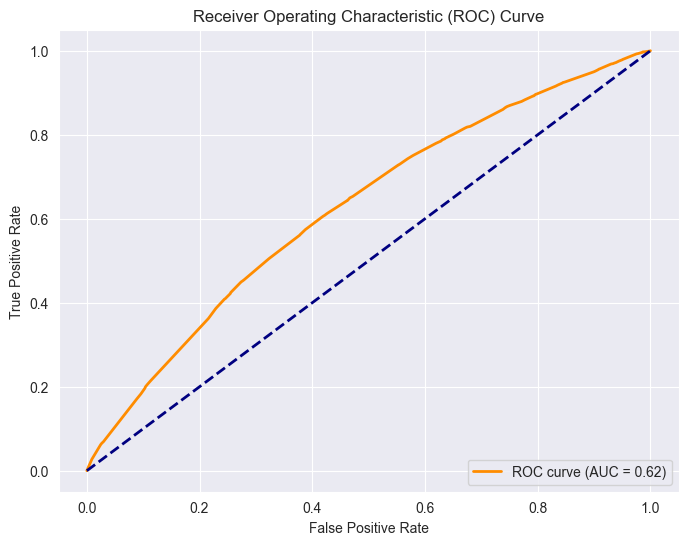

Gini : 0.24899796109517602 , AUC : 0.624498980547588


In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

features = ['REGION_RATING_CLIENT_W_CITY_disc', 'DAYS_CREDIT_ENDDATE_disc', 'RATE_DOWN_PAYMENT_disc', 'AMT_PAYMENT_disc', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE']


replacement_dict = {1: 'un', 0: 'zero', 2: 'deux', 3: 'trois'}

df_train = X_train.copy()
df_validation = X_test.copy()

for var in features:
   df_train[var] = df_train[var].replace(replacement_dict)
   df_validation[var] = df_validation[var].replace(replacement_dict)


df_train["TARGET"] = df_train["TARGET"].astype("int")


reference_categories = {var: df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()#_regularized(alpha = 1.5)

# Prédiction
pred = logit_model.predict(df_validation)
fpr, tpr, thresholds = roc_curve(df_validation["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
print(f'Gini : {gini_coefficient} , AUC : {roc_auc}')

In [139]:
logit_model.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-2.120656,0.014182,-149.536058,0.000000e+00,-2.148451,-2.092861
"C(REGION_RATING_CLIENT_W_CITY_disc, Treatment(reference=""zero""))[T.un]",0.457519,0.019406,23.575965,6.801203e-123,0.419483,0.495554
"C(DAYS_CREDIT_ENDDATE_disc, Treatment(reference=""un""))[T.zero]",-0.473582,0.015941,-29.707612,6.123224e-194,-0.504827,-0.442338
"C(RATE_DOWN_PAYMENT_disc, Treatment(reference=""zero""))[T.un]",-0.270207,0.017788,-15.190483,4.088953e-52,-0.305070,-0.235343
"C(AMT_PAYMENT_disc, Treatment(reference=""un""))[T.zero]",0.220007,0.016073,13.687985,1.197859e-42,0.188504,0.251509
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.other]",-0.552888,0.020158,-27.428049,1.269873e-165,-0.592396,-0.513379
"C(OCCUPATION_TYPE_discret, Treatment(reference=""low_skilled""))[T.high_skilled]",-0.412497,0.019994,-20.631154,1.441677e-94,-0.451685,-0.373310
"C(NAME_CONTRACT_TYPE, Treatment(reference=""Cash loans""))[T.Revolving loans]",-0.544416,0.030963,-17.582832,3.334970e-69,-0.605102,-0.483730


# Xgboost

In [140]:
train_prepared2 = train_prepared[['REGION_RATING_CLIENT_W_CITY_disc', 'DAYS_CREDIT_ENDDATE_disc', 'RATE_DOWN_PAYMENT_disc', 'AMT_PAYMENT_disc', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE','TARGET']].copy()

for col in train_prepared2.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared2[col], prefix=col, drop_first=True)
    train_prepared2 = train_prepared2.drop(col, axis=1)
    train_prepared2 = train_prepared2.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in train_prepared2.select_dtypes(include=bool).columns:
    train_prepared2[col] = train_prepared2[col].astype(int)

In [141]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for col in train_prepared2.select_dtypes(include='number').columns: 
    train_prepared2[col] = scaler.fit_transform(train_prepared2[[col]])


In [142]:
X = train_prepared2.drop(columns = ['TARGET'])
y = train_prepared2['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [143]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [144]:
X_test2.columns 

Index(['REGION_RATING_CLIENT_W_CITY_disc', 'DAYS_CREDIT_ENDDATE_disc',
       'RATE_DOWN_PAYMENT_disc', 'AMT_PAYMENT_disc',
       'NAME_INCOME_TYPE_discret_other', 'OCCUPATION_TYPE_discret_low_skilled',
       'NAME_CONTRACT_TYPE_Revolving loans'],
      dtype='object')

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score

liste_var =X_train2.columns

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Utilisation de l'aire sous la courbe ROC comme métrique d'évaluation
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2[liste_var], y_train)
    y_pred_proba = model.predict_proba(X_test2[liste_var])[:, 1]  # Probabilité de la classe positive
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Calcul de l'aire sous la courbe ROC
    return auc_score

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-25 18:53:47,479] A new study created in memory with name: no-name-bcd55f4b-4e99-476b-b2af-0dafbc205e89
[I 2024-02-25 18:53:48,393] Trial 0 finished with value: 0.624671283212477 and parameters: {'max_depth': 4, 'eta': 0.05406482151353324, 'gamma': 0.8433139193407898, 'colsample_bytree': 0.7264227162046517, 'subsample': 0.780186524313353, 'n_estimators': 91, 'alpha': 0.06125547645910906}. Best is trial 0 with value: 0.624671283212477.
[I 2024-02-25 18:53:49,366] Trial 1 finished with value: 0.6249468446881459 and parameters: {'max_depth': 16, 'eta': 0.056964251643372155, 'gamma': 3.5856273016606274e-05, 'colsample_bytree': 0.5255206613422296, 'subsample': 0.8227323472219793, 'n_estimators': 134, 'alpha': 0.8595528328626219}. Best is trial 1 with value: 0.6249468446881459.
[I 2024-02-25 18:53:51,007] Trial 2 finished with value: 0.6242425679974711 and parameters: {'max_depth': 14, 'eta': 0.2007898259565357, 'gamma': 4.6635341816546034e-08, 'colsample_bytree': 0.600635810281114

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train2[liste_var].iloc[:150, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train2[liste_var].iloc[:150, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train2[liste_var].iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2[liste_var].iloc[[0]])